### Procesamiento de Palabras

0. Agregar una columna que mide el porcentaje de inglés usado en el tweet  y ver con eso  cuántos son en inglés ( tweets que superan cierto threshold de inglés)
1. Diferenciar preguntas de afirmaciones (relacionar con el target)
2. Tweet “inutiles” (tweets sin palabras ingles, cosas raras)



In [6]:
#IMPORTS

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys,os
%run ../datuslib.ipynb

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

In [21]:
# 1. Diferenciar preguntas de afirmaciones (relacionar con el target)

# ANALISIS BASICO (Validez = 1 palabra en ingles)

¿Que constituye una pregunta? Un tweet que tenga al menos 1 palabra en ingles antes de un signo de pregunta.
¿Que constituye una afirmacion? Un tweet que tenga al menos 1 palabra en ingles.

In [22]:
df = pd.read_csv("../Data/train.csv")
df.text.isnull().sum() #no hay textos vacios

0

In [9]:
df['textosValidos'] = df.text.map(lambda x: hasEnglishWord(x)) 

In [10]:
df = df[df.textosValidos]

In [14]:
df['esPregunta'] = df.text.map(lambda x: isQuestion(x))  

In [15]:
df['preguntasConDesastre'] = df.esPregunta & df.target
df['preguntasSinDesastre'] = df.esPregunta & (df.target.apply(lambda x: 1 if x == 0 else 0))

Text(0, 0.5, 'Name of Category')

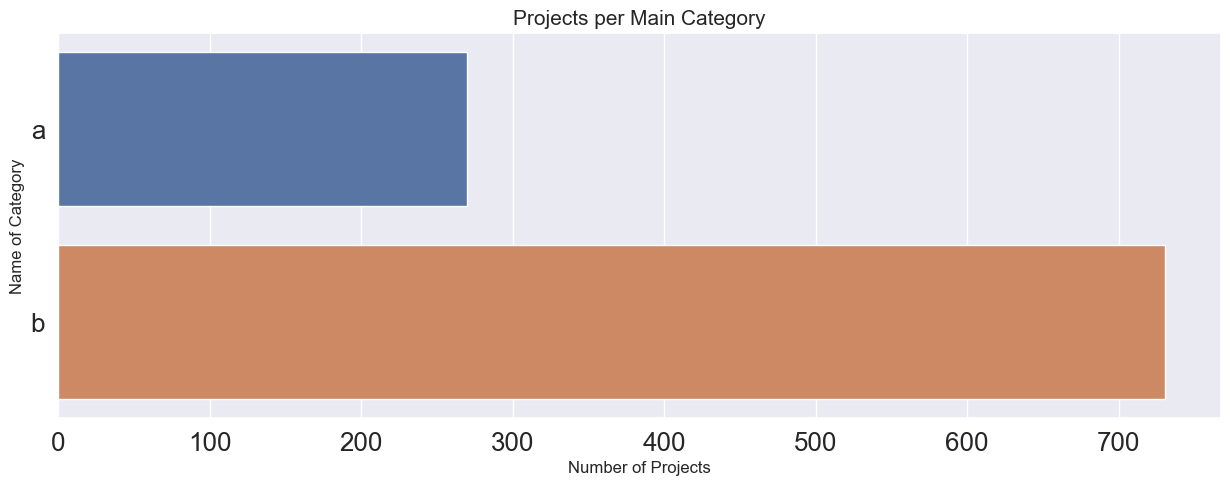

In [20]:
g = sns.barplot
(x=[df.preguntasConDesastre.sum(), df.preguntasSinDesastre.sum()], y=['a','b'], orient='h')
g.set_title("Projects per Main Category", fontsize=15)
g.set_xlabel("Number of Projects", fontsize=12)
g.set_ylabel("Name of Category", fontsize=12)